# Animal Sequence Emergence Predictions

For each animal sequence:
1. Compute the HA and NA risk using Emergenet (using pretrained Enets from all human strains within 1 year of the present, **1/1/2023 - 1/1/2024**)
2. Predict IRAT emergence scores with `emergenet.emergenet.predict_irat_emergence`
3. Save results: `results/animal_predictions/animal.csv`

    
### Running Processes

Computations are done in:
- `animal_predictions.py`
- `run_animal_predictions.sh`

To run, navigate to terminal and do

`chmod ugo+rwx run_animal_predictions.sh`

`./run_animal_predictions.sh`

In [8]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm, shapiro, kstest, anderson
import seaborn as sns
plt.style.use('default')
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 300
import warnings
warnings.filterwarnings('ignore')
from emergenet.emergenet import predict_irat_emergence


RESULT_DIR = 'results/animal_predictions/'

In [2]:
# Get list of all subsets
pattern = 'animal[0-9]*.csv'
file_list = glob.glob(f'{RESULT_DIR}/{pattern}')
animal = pd.DataFrame()
for file in file_list:
    df = pd.read_csv(file)
    animal = pd.concat([animal, df], ignore_index=True)

# Predict emergence risk
animal['geom_mean_risk'] = np.sqrt(animal['ha_risk'] * animal['na_risk'])
animal[['emergence', 'emergence_low', 'emergence_high']] = animal.apply(lambda row: predict_irat_emergence(row['ha_risk'], row['na_risk']), axis=1, result_type='expand')
animal = animal.sort_values(by='emergence', ascending=False).reset_index(drop=True)
animal.to_csv(RESULT_DIR + 'animal.csv', index=False)
animal[['name', 'subtype', 'date', 'emergence']].round(3)

,name,subtype,date,emergence
0,A/swine/Iowa/CEIRS-1495/2023,H1N2,2023-06-15,7.733
1,A/swine/Tver_region/RII-81-1S/2023,H1N1,2023-02-17,7.733
2,A/swine/Missouri/A02524408/2023,H3N2,2023-01-13,7.733
3,A/swine/North_Carolina/A02751333/2022,H3N2,2022-12-13,7.733
4,A/swine/Indiana/A01812310/2020,H1N1,2020-08-17,7.732
...,...,...,...,...
6349,A/chicken/China/2106/2021,H9N2,2021-11-30,3.054
6350,A/chicken/China/2034/2020,H9N2,2020-01-20,3.050
6351,A/chicken/China/2040/2020,H9N2,2020-01-10,3.050
6352,A/green-winged-teal/Georgia/DT-22246/2020,H5N8,2020-09-29,3.046


## Combine Animal + IRAT

Add a dummy column to the animal predictions, indicating whether the sequence is from IRAT.

In [9]:
irat = pd.read_csv('results/irat_predictions/irat.csv')
irat_with_accessions = pd.read_csv('data/irat.csv')[['Influenza Virus', 'HA Accession', 'NA Accession']]
irat = irat.merge(irat_with_accessions, on='Influenza Virus', how='left')
animal = pd.read_csv('results/animal_predictions/animal.csv')
irat['is_irat'] = 1
animal['is_irat'] = 0
irat = irat[['Influenza Virus', 'Virus Type', 'Date of Risk Assessment',
             'HA Accession', 'HA Sequence', 'NA Accession', 'NA Sequence', 
             'HA Risk', 'NA Risk', 'Geom Mean Risk', 'Predicted Emergence',
             'Predicted Emergence Low', 'Predicted Emergence High',
             'is_irat', 'Emergence Score', 'Impact Score',
             'Mean Low Acceptable Emergence', 'Mean High Acceptable Emergence',
             'Mean Low Acceptable Impact', 'Mean High Acceptable Impact',]]

irat.columns = list(animal.columns) + ['emergence_score', 'impact_score', 
                                       'mean_low_acceptable_emergence', 'mean_high_acceptable_emergence', 
                                       'mean_low_acceptable_impact', 'mean_high_acceptable_impact']
combined = pd.concat([irat, animal], ignore_index=True)
combined.to_csv(RESULT_DIR + 'animal_combined_with_irat.csv', index=False)

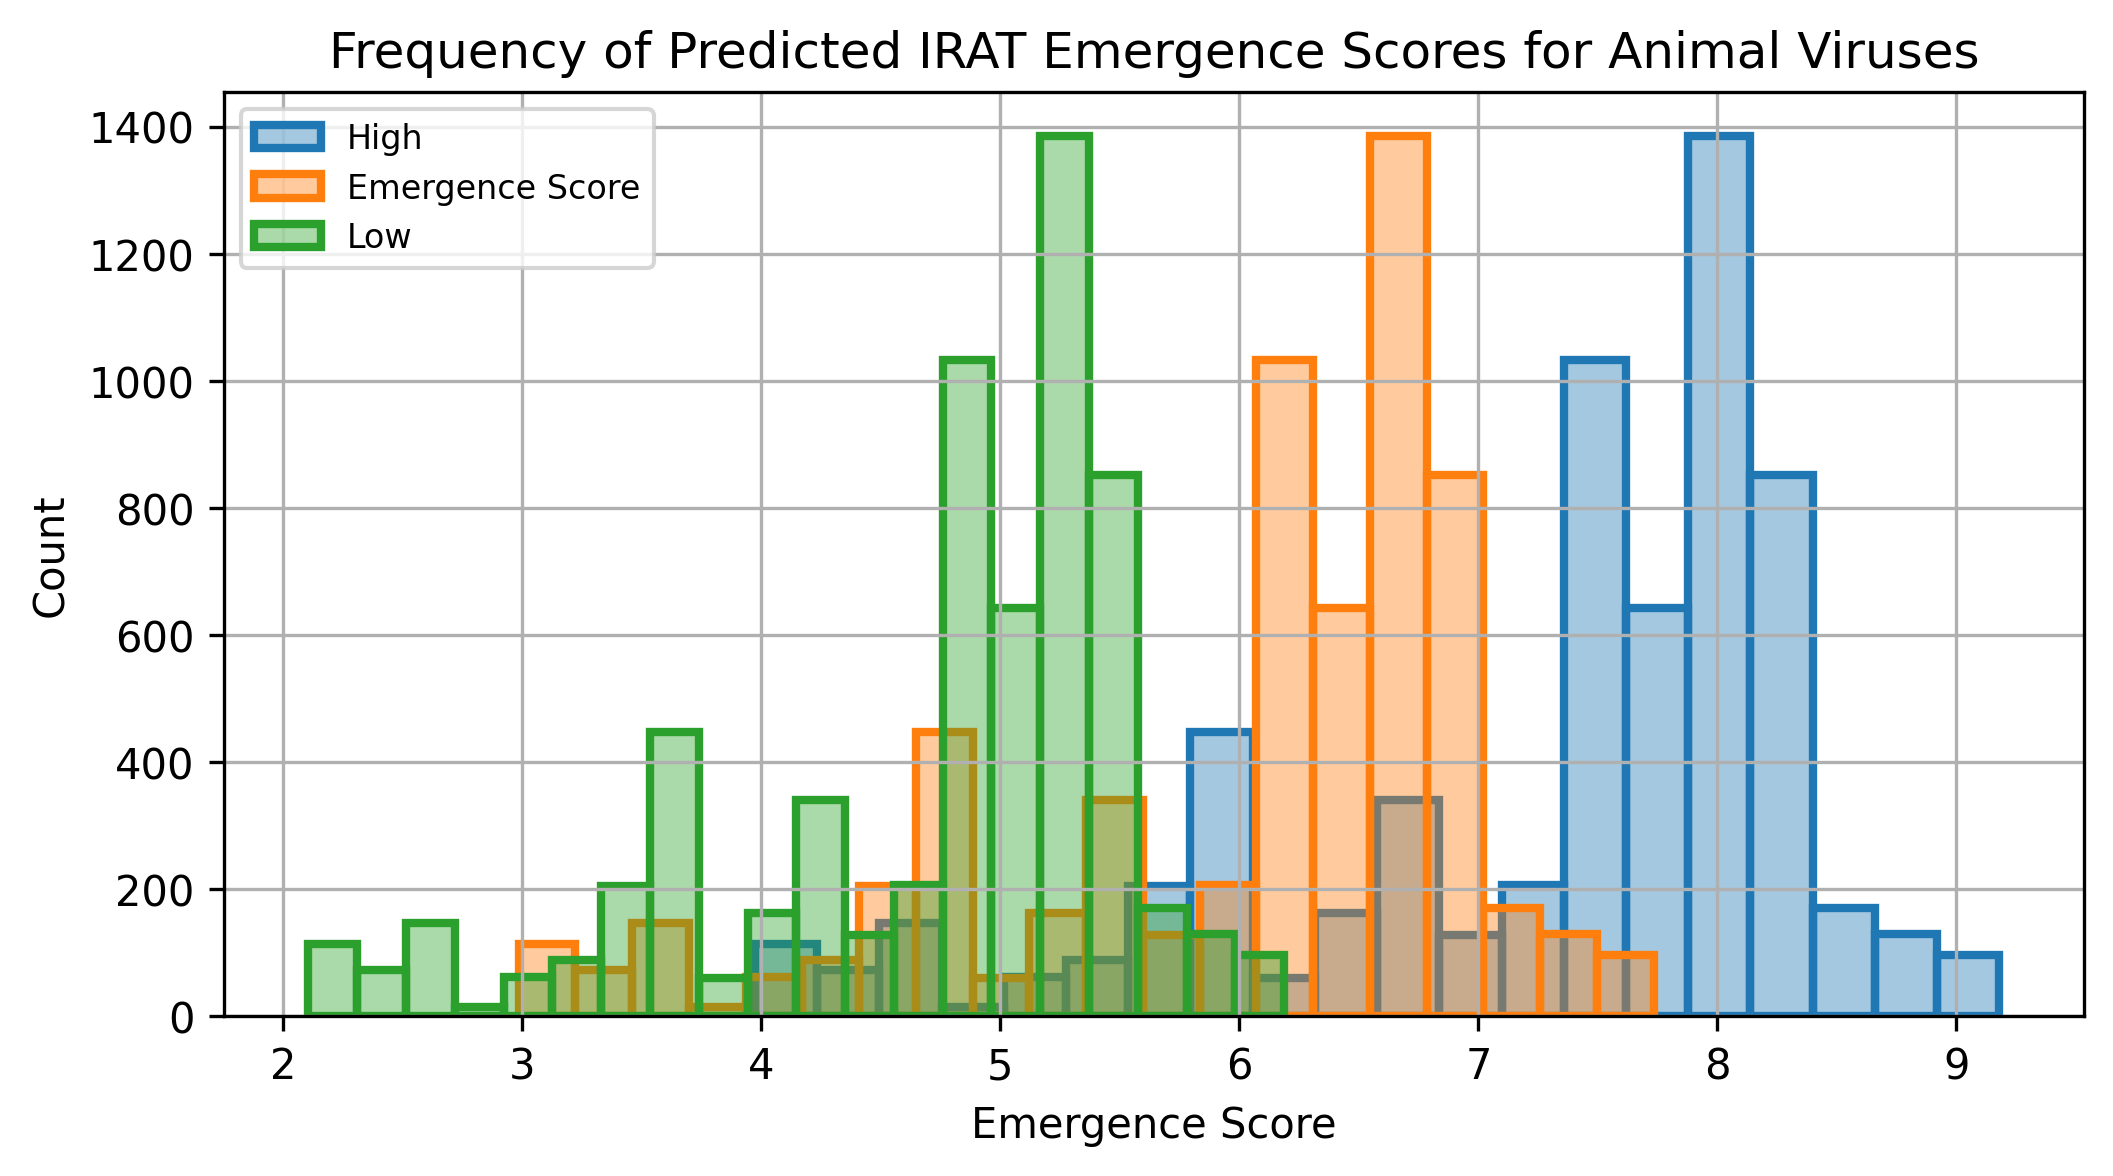

In [10]:
sns.histplot(animal['emergence_high'], label='High', alpha=0.4, color='#1f77b4', linewidth=2, edgecolor='#1f77b4', bins=20)
sns.histplot(animal['emergence'], label='Emergence Score', alpha=0.4, color='#ff7f0e', linewidth=2, edgecolor='#ff7f0e', bins=20)
sns.histplot(animal['emergence_low'], label='Low', alpha=0.4, color='#2ca02c', linewidth=2, edgecolor='#2ca02c', bins=20)

plt.xlabel('Emergence Score')
plt.title('Frequency of Predicted IRAT Emergence Scores for Animal Viruses')
plt.grid()
plt.legend(fontsize=8)
plt.savefig('tables/animal.png',bbox_inches='tight',transparent=True);

## Plots

Fitted normal distribution parameters: mu = 6.676, std = 0.164
Tail threshold (90th percentile): 7.196
Tail data: [7.733 7.733 7.733 7.733 7.636 7.599 7.423 7.415 7.412 7.339 7.205]
Tail p-value: 0.001
The tail is extreme with a p-value of 0.001, which is less than the significance level of 0.050.


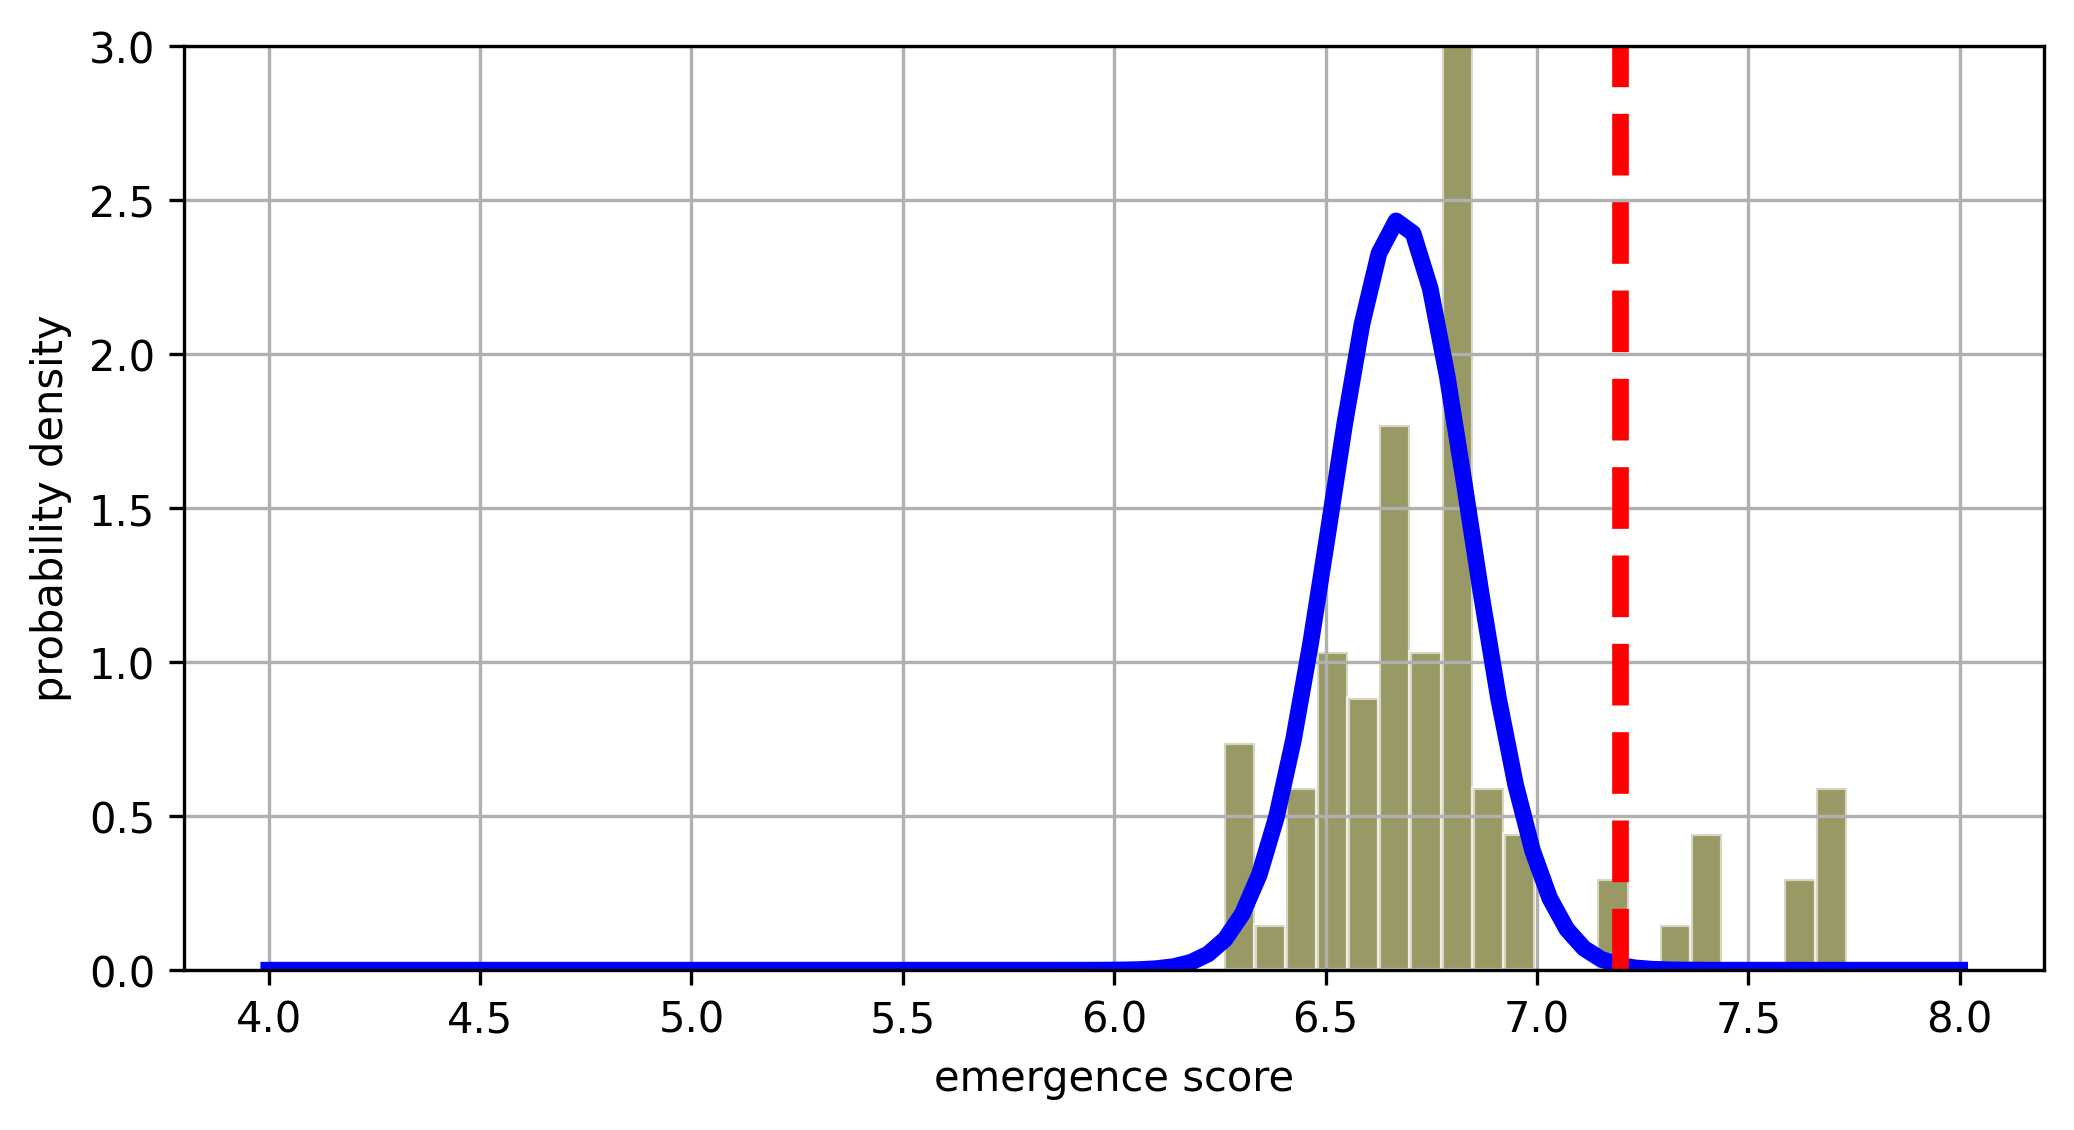

In [11]:
collapseddf=pd.read_csv('../../paper_data_v1/irat_qnet/results/animal_predictions/allriskystrains_collapsed.csv')
collapseddf.columns
data = collapseddf.emergence_risk.values

# Fit a normal distribution to the entire data
data1=data[data<6.9]
data1=data1[data1>6]
mu, std = norm.fit(data1)
print(f'Fitted normal distribution parameters: mu = {mu:.3f}, std = {std:.3f}')

# Plot the fitted normal distribution
xmin, xmax = 4,8
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'b', linewidth=4)
plt.hist(data, bins=20, density=True, alpha=0.6, color='#555500',edgecolor='w')

plt.gca().set_ylim(None,3)
plt.gca().set_ylabel('probability density')
plt.gca().set_xlabel('emergence score')

# Tail analysis using the normal distribution
tail_threshold = np.percentile(data, 88)
print(f'Tail threshold (90th percentile): {tail_threshold:.3f}')
plt.plot(tail_threshold*np.array([1,1]),[0,3],'--r', linewidth=4)
plt.grid()

# Extract the tail data
tail_data = data[data > tail_threshold]
print(f'Tail data: {np.round(tail_data, 3)}')

# Calculate p-value for the tail using the normal distribution
tail_p_value = 1 - norm.cdf(min(tail_data), mu, std)
print(f'Tail p-value: {tail_p_value:.3f}')

# Interpretation of the p-value
significance_level = 0.05
if tail_p_value < significance_level:
    print(f'The tail is extreme with a p-value of {tail_p_value:.3f}, which is less than the significance level of {significance_level:.3f}.')
else:
    print(f'The tail is not considered extreme with a p-value of {tail_p_value:.3f}, which is greater than the significance level of {significance_level:.3f}.')

Tail threshold (90th percentile): 7.105
Tail data: [7.733 7.733 7.733 7.733 7.636 7.599 7.423 7.415 7.412 7.339 7.205]
Fitted log-normal distribution parameters: shape = 0.037, loc = 0.000, scale = 6.494
Tail p-value: 0.002
The tail is extreme with a p-value of 0.002, which is less than the significance level of 0.050.


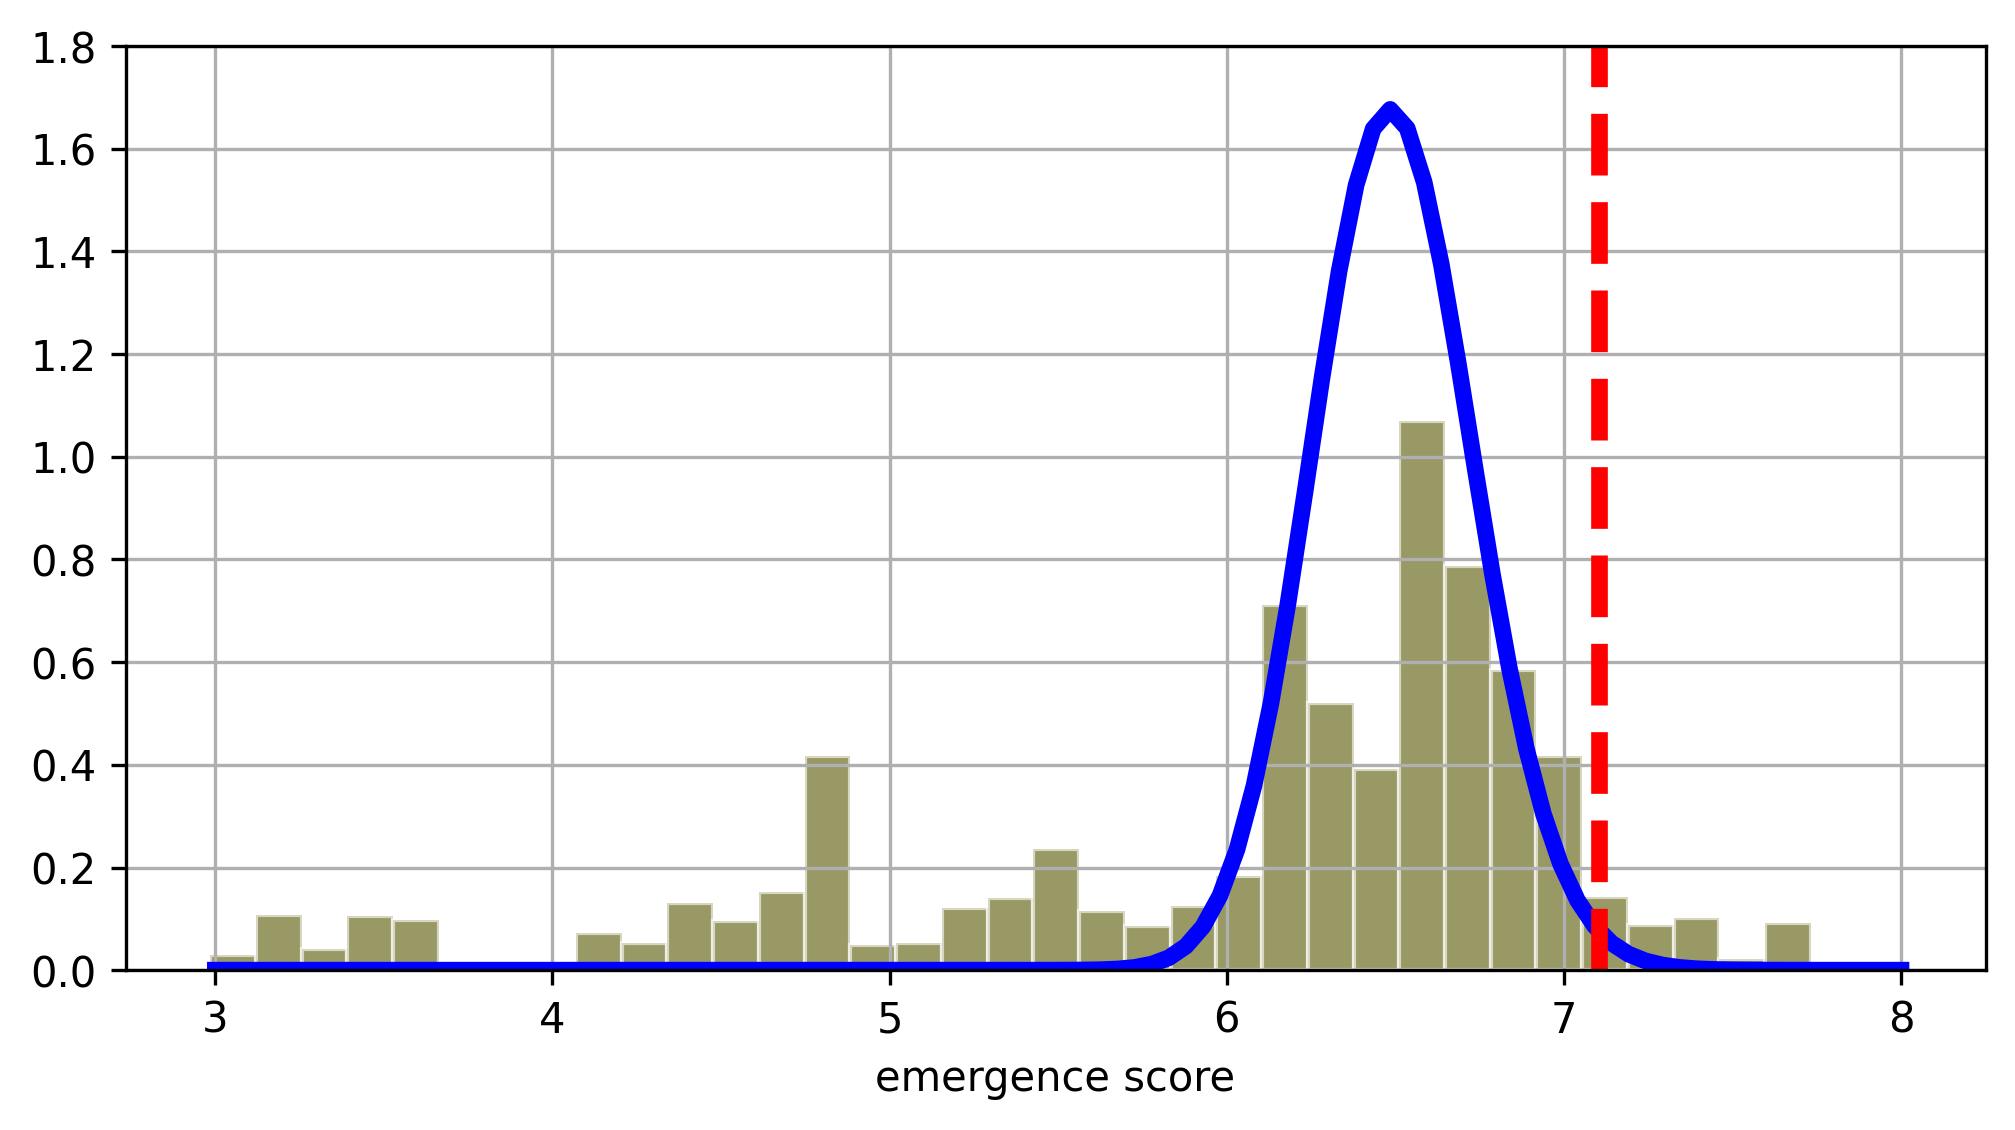

In [12]:
animal = pd.read_csv('results/animal_predictions/animal.csv')
data=animal['emergence'].values

# Fit a log-normal distribution to the tail data
tail_threshold = np.percentile(data, 95)
tail_threshold1 = np.percentile(data, 90)
print(f'Tail threshold (90th percentile): {tail_threshold:.3f}')

# Extract the tail data
data2 = data[data < 6.9]
data2 = data2[data2 > 6]
print(f'Tail data: {np.round(tail_data, 3)}')

# Fit a log-normal distribution to the tail data
shape, loc, scale = lognorm.fit(data2, floc=0)
print(f'Fitted log-normal distribution parameters: shape = {shape:.3f}, loc = {loc:.3f}, scale = {scale:.3f}')

# Plot the fitted log-normal distribution
xmin, xmax = 3,8
x = np.linspace(xmin, xmax, 100)
p = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, p, 'b', linewidth=4)
plt.hist(data, bins=35, density=True, alpha=0.6, color='#555500',edgecolor='w')
plt.plot(tail_threshold*np.array([1,1]),[0,1.8],'--r', linewidth=4)
plt.gca().set_ylim(None,1.8)
plt.gca().set_xlabel('emergence score')
plt.grid()

# Calculate p-value for the tail using the log-normal distribution
tail_p_value = 1 - lognorm.cdf(min(tail_data), shape, loc, scale)
print(f'Tail p-value: {tail_p_value:.3f}')

# Interpretation of the p-value
significance_level = 0.05
if tail_p_value < significance_level:
    print(f'The tail is extreme with a p-value of {tail_p_value:.3f}, which is less than the significance level of {significance_level:.3f}.')
else:
    print(f'The tail is not considered extreme with a p-value of {tail_p_value:.3f}, which is greater than the significance level of {significance_level:.3f}.')

In [13]:
len(data[data>7])/len(data)

0.06436890147938307

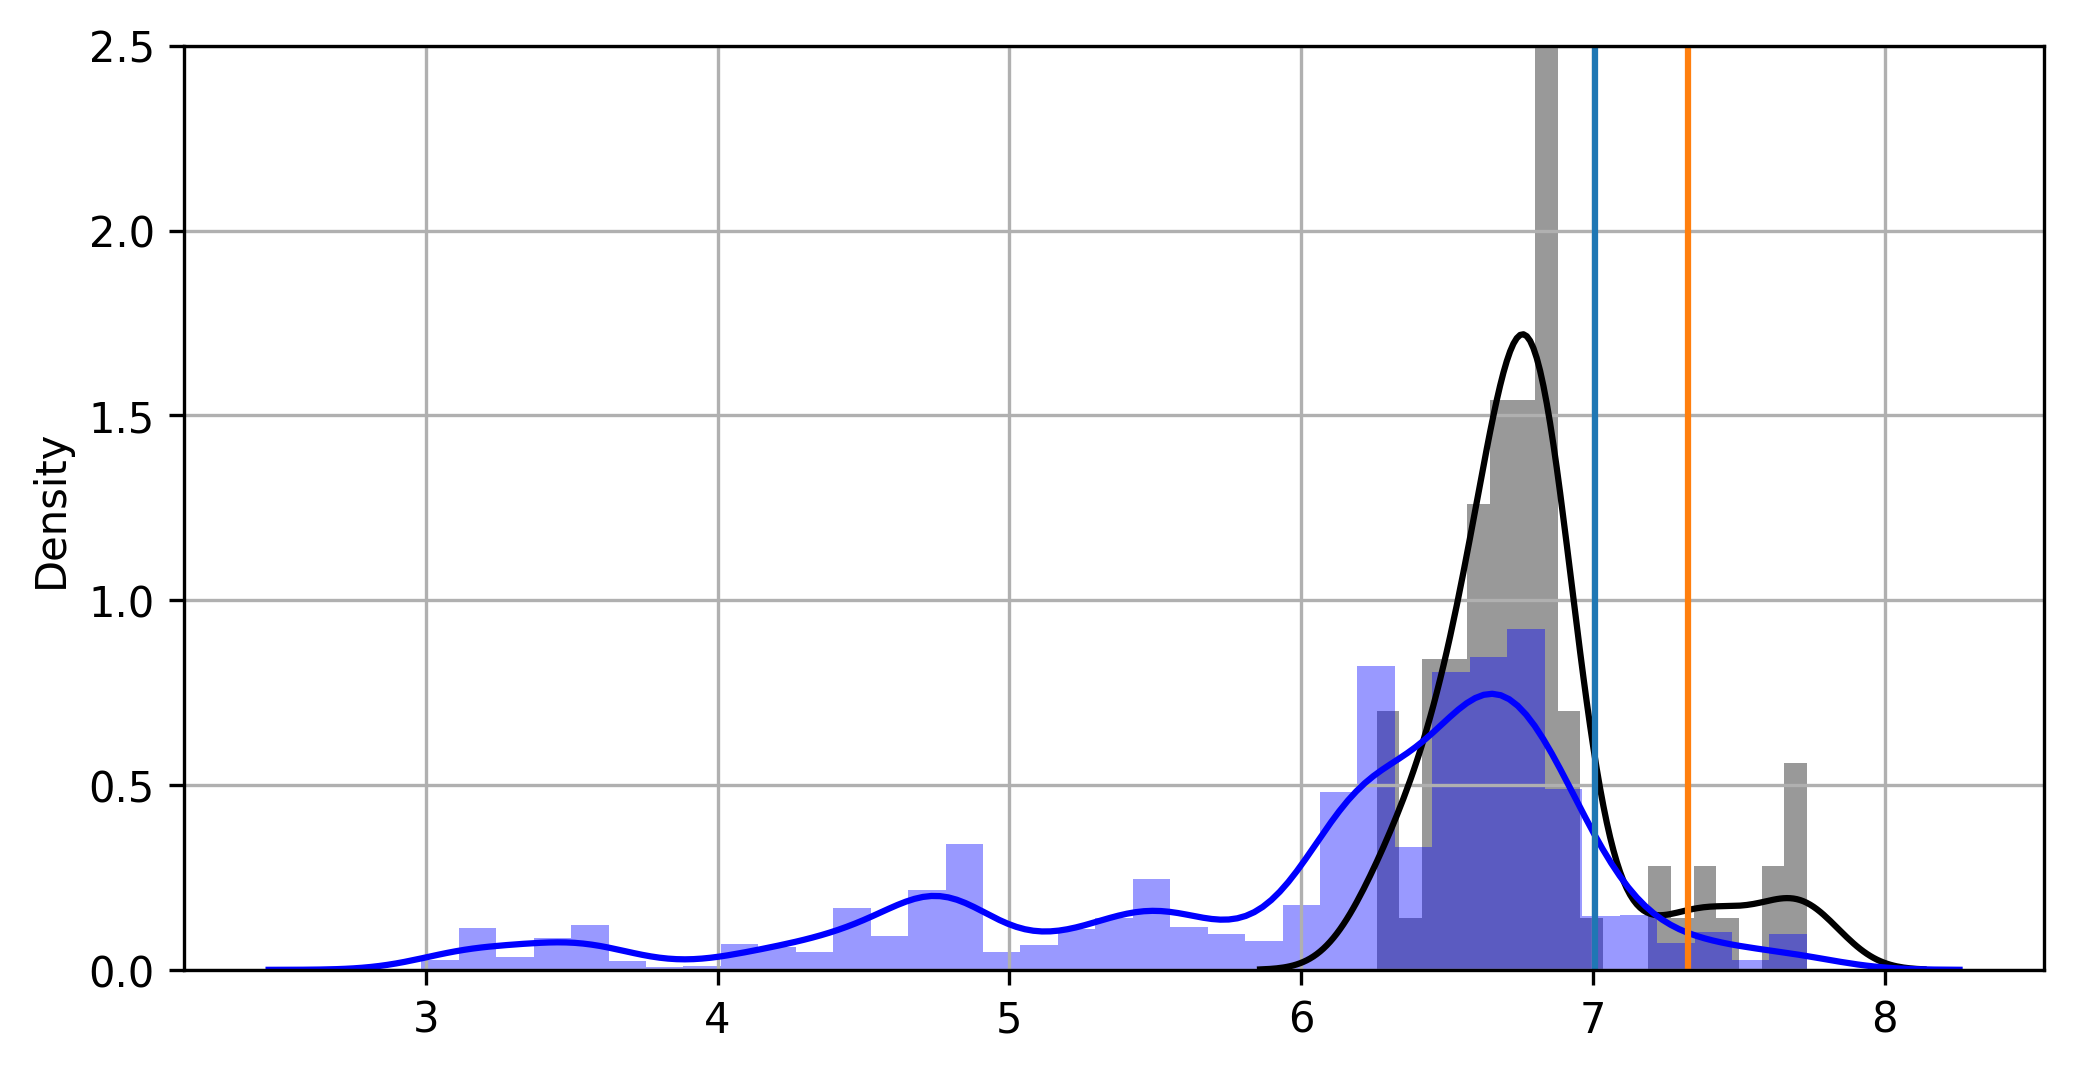

In [14]:
ax=sns.distplot(collapseddf.emergence_risk.values,norm_hist=True,color='#000000')
X=animal['emergence'].values
sns.distplot(X,ax=ax,norm_hist=True,color='b')
ylim=ax.get_ylim()
Q=[np.quantile(collapseddf.emergence_risk.values,q=x) for x in [.87,.9]]
ax.plot([Q[0],Q[0]],ylim)
ax.plot([Q[1],Q[1]],ylim)
ax.set_ylim(ylim[0],2.5)
plt.grid()
Q;